# Bonus assignment
# Kuntal Ghosh
# CHEM 31300

# I: Data preparation

In [1]:
# Importing all modules

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load data
csv_file = 'MD_properties.csv'
df = pd.read_csv(csv_file)
smiles_list = df['SMILES'].astype(str).tolist()
e_coh = df['E_coh (MPa)'].values.astype(np.float32)

# Min-Max normalization
e_coh_min, e_coh_max = e_coh.min(), e_coh.max()
e_coh_norm = (e_coh - e_coh_min) / (e_coh_max - e_coh_min)

# Build character vocabulary (0 reserved for padding)
all_chars = set(''.join(smiles_list))
char2idx = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
idx2char = {idx: char for char, idx in char2idx.items()}

# Tokenize and pad SMILES
max_len = max(len(s) for s in smiles_list)
tokenized_smiles = [[char2idx[char] for char in s] for s in smiles_list]
padded_smiles = [seq + [0] * (max_len - len(seq)) for seq in tokenized_smiles]

# Convert to tensors
padded_smiles = torch.tensor(padded_smiles, dtype=torch.long)
e_coh_norm = torch.tensor(e_coh_norm, dtype=torch.float32)

# Splitting into a 80/10/10 proportion (train/validation/test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    padded_smiles, e_coh_norm, test_size=0.1, random_state=31
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42
)

# DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# II: Constructing the encoder and decoder

In [2]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=256, latent_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.fc_mean = nn.Linear(2*hidden_size + 1, latent_dim)
        self.fc_logvar = nn.Linear(2*hidden_size + 1, latent_dim)

    def forward(self, smiles, e_coh):
        embedded = self.embedding(smiles)
        _, (h_n, _) = self.lstm(embedded)
        h_combined = torch.cat([h_n[-2], h_n[-1]], dim=1)
        h_property = torch.cat([h_combined, e_coh.unsqueeze(1)], dim=1)
        mean = self.fc_mean(h_property)
        logvar = self.fc_logvar(h_property)
        return mean, logvar

def reparameterize(mean, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mean + eps * std

Importance of reparameterization trick in VAE: In a VAE, the input data is mapped into a latent space, defined by a probability distribution, and the decoder constructs samples from this. Directly sampling from a probabilistic parameter distribution introduces stochasticity, which in turn makes the gradients with respect to the parameters ill-defined. This makes backpropagation, and hence the parameterization of the neural network very difficult. To bypass this, the reparameterization trick is used which effectively separates the randomness (eps, drawn from a normal distribution) from the learnable parameters, allowing computation of well-defined gradients and hence effective backpropagation.

In [3]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=256, latent_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim + latent_dim + 1, hidden_size, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.init_h = nn.Linear(latent_dim + 1, hidden_size)
        self.init_c = nn.Linear(latent_dim + 1, hidden_size)

    def forward(self, z, e_coh, max_len, device, targets=None):
        batch_size = z.size(0)
        latent_property = torch.cat([z, e_coh.unsqueeze(1)], dim=1)
        h_0 = self.init_h(latent_property).unsqueeze(0)
        c_0 = self.init_c(latent_property).unsqueeze(0)
        input = torch.zeros(batch_size, dtype=torch.long).to(device)
        outputs = []
        for t in range(max_len):
            embedded = self.embedding(input).unsqueeze(1)
            lp_expanded = latent_property.unsqueeze(1).expand(-1, embedded.size(1), -1)
            lstm_input = torch.cat([embedded, lp_expanded], dim=-1)
            out, (h_0, c_0) = self.lstm(lstm_input, (h_0, c_0))
            logits = self.fc_out(out.squeeze(1))
            outputs.append(logits)
            input = targets[:, t] if targets is not None else logits.argmax(-1)
        return torch.stack(outputs, dim=1)

class PropertyVAE(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=256, latent_dim=32):
        super().__init__()
        self.encoder = Encoder(vocab_size, embedding_dim, hidden_size, latent_dim)
        self.decoder = Decoder(vocab_size, embedding_dim, hidden_size, latent_dim)

    def forward(self, smiles, e_coh):
        mean, logvar = self.encoder(smiles, e_coh)
        z = reparameterize(mean, logvar)
        recon_smiles = self.decoder(z, e_coh, smiles.size(1), smiles.device, smiles)
        return recon_smiles, mean, logvar

# III: Defining the loss function

In [4]:
def vae_loss(recon_smiles, target_smiles, mean, logvar):
    CE = F.cross_entropy(
        recon_smiles.view(-1, recon_smiles.size(-1)),
        target_smiles.view(-1),
        ignore_index=0
    )
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1)
    KLD = torch.mean(KLD)
    return CE + KLD

Need for such a loss function: The cross-entropy term helps the model accurately reconstruct the input data. The KL divergence term on the other hand kind of acts as a regularizer, and ensures that the decoder can effectively and smoothly sample from the latent space, thereby generating new, faithful samples.

# IV: Training the model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(char2idx) + 1  # +1 for padding index 0
model = PropertyVAE(vocab_size).to(device)
# Add weight_decay for L2 regularization (e.g., 1e-4 or 1e-5 is typical)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

Need for L2 regularization: Prevents overfitting and helps the model better generalize to unseen (test) data. The L2 penalty term is also smooth and differentiable and leads to stable fitting.

Epoch 1/50 | Train Loss: 2.8106 | Val Loss: 2.1405 | Test Loss: 1.9866
Epoch 2/50 | Train Loss: 1.8328 | Val Loss: 1.7637 | Test Loss: 1.5548
Epoch 3/50 | Train Loss: 1.4958 | Val Loss: 1.5066 | Test Loss: 1.2997
Epoch 4/50 | Train Loss: 1.2911 | Val Loss: 1.3864 | Test Loss: 1.1506
Epoch 5/50 | Train Loss: 1.1871 | Val Loss: 1.3092 | Test Loss: 1.0657
Epoch 6/50 | Train Loss: 1.0924 | Val Loss: 1.2442 | Test Loss: 1.0114
Epoch 7/50 | Train Loss: 1.0259 | Val Loss: 1.1985 | Test Loss: 0.9615
Epoch 8/50 | Train Loss: 0.9815 | Val Loss: 1.1540 | Test Loss: 0.9342
Epoch 9/50 | Train Loss: 0.9310 | Val Loss: 1.1327 | Test Loss: 0.9056
Epoch 10/50 | Train Loss: 0.9000 | Val Loss: 1.1038 | Test Loss: 0.8854
Epoch 11/50 | Train Loss: 0.8700 | Val Loss: 1.0888 | Test Loss: 0.8669
Epoch 12/50 | Train Loss: 0.8226 | Val Loss: 1.0751 | Test Loss: 0.8476
Epoch 13/50 | Train Loss: 0.8167 | Val Loss: 1.0565 | Test Loss: 0.8469
Epoch 14/50 | Train Loss: 0.7858 | Val Loss: 1.0372 | Test Loss: 0.8306
E

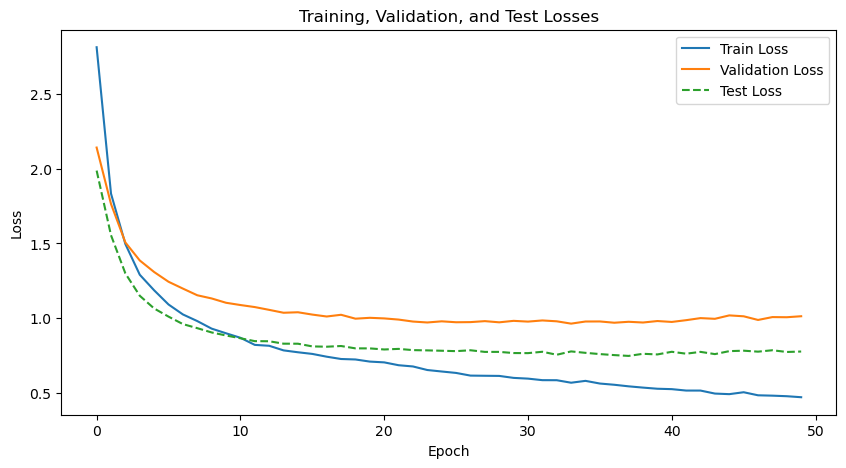

In [6]:
# Lists to store losses
train_losses = []
val_losses = []
test_losses = []

n_epochs = 50
best_val_loss = float('inf')
patience = 100
patience_counter = 0

for epoch in range(n_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for smiles, e_coh in train_loader:
        smiles, e_coh = smiles.to(device), e_coh.to(device)
        optimizer.zero_grad()
        recon_smiles, mean, logvar = model(smiles, e_coh)
        loss = vae_loss(recon_smiles, smiles, mean, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for smiles, e_coh in val_loader:
            smiles, e_coh = smiles.to(device), e_coh.to(device)
            recon_smiles, mean, logvar = model(smiles, e_coh)
            val_loss += vae_loss(recon_smiles, smiles, mean, logvar).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Test loss (per epoch)
    test_loss = 0.0
    with torch.no_grad():
        for smiles, e_coh in test_loader:
            smiles, e_coh = smiles.to(device), e_coh.to(device)
            recon_smiles, mean, logvar = model(smiles, e_coh)
            test_loss += vae_loss(recon_smiles, smiles, mean, logvar).item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Test Loss: {test_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Losses')
plt.legend()
plt.show()

Observations: The training loss is decreasing steadily, but the validation loss initially decreased, levelled off and then has a slight increase. This may indicate some level of overfitting. However, as the test loss remains reasonably steady, the model can be said to perform moderately well on new data. Increasing the number of training epochs can probably improve the model.

# V: Inverse Design (generating SMILES representations)

In [7]:
model.eval()

generated_smiles = []
test_property_values = []

with torch.no_grad():
    for _, e_coh in test_loader:  # Only use E_coh, not SMILES
        e_coh = e_coh.to(device)
        batch_size = e_coh.size(0)
        
        # Sample latent vector from standard normal distribution
        latent_dim = model.decoder.init_h.weight.size(1) - 1  # Subtract 1 for property
        z = torch.randn(batch_size, latent_dim).to(device)
        
        # Generate SMILES for each property value in the batch
        recon_smiles_logits = model.decoder(z, e_coh, max_len, device, targets=None)
        
        # Convert logits to predicted token indices (greedily)
        pred_smiles = torch.argmax(recon_smiles_logits, dim=-1).cpu().numpy()
        
        # Convert token indices back to SMILES strings
        for i in range(batch_size):
            tokens = pred_smiles[i]
            tokens = tokens[tokens != 0]  # Remove padding (index 0)
            smiles_str = ''.join([idx2char[idx] for idx in tokens if idx in idx2char])
            generated_smiles.append(smiles_str)
            test_property_values.append(e_coh[i].item())

# Optionally, print or save the results
print("Generated SMILES and their E_coh values:")
for smiles, e_coh in zip(generated_smiles, test_property_values):
    print(f"{smiles}\t{e_coh:.4f}")

Generated SMILES and their E_coh values:
C=CC(=O)N1CCCC1CC(=O)OCCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOC(=O)C=C(C)C(=O)C=CC(=O)	0.3737
C=CC(=O)Nc1cccc(C(=O)OCC)cc1OCCCCCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOC(=O)C=C(C	0.2261
C=CC(=O)N1CCCC1CCN(C)C1CCOC1=O)C1CCN(C)C1=O)C1CCN(C)C1=O)C1CCN(C)C1=O)C1CCN(C)C1=O)C1	0.5229
C=CC(=O)N1CCCC(CC(=O)O)C1CCOC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOC(=O)C=C(C	0.2955
C=CC(=O)N1CCC(C(=O)OC)CC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOC(=O)C=C)C1=OCCOCCOCC	0.5222
C=CC(=O)N1CCC(C(=O)NC(C)C)CC1CCOC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOC(=O)C=C(C)C(=O)C=	0.2734
C=CC(=O)Nc1ccc(C(=O)OCC)cc1C(=O)OCC)c1C(=O)OCC)c1C(=O)OCCOCC1)C(C)C1CCOC1CCOCC1CCOCC1	0.4562
C=CC(=O)N1CCCC1CCN(C)C1CC1CCOC1=O)C1=O)C1CCN(C)C1CC1CCOC1=O)C1=O)C1CCN(C)C1=O)C1CCN(C	0.9870
C=CC(=O)Nc1ccc(C(=O)OCC)cc1OCCCCCCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1=	0.3604
C=CC(=O)Nc1ccc(C(=O)OCC)cc1C(=O)OCC)c1C(C)(C)C)c1ccccc1C(=O)OCCCCCCCCCCC1CCOCC1CCOCC1	0.3285
C=CC(=O)Nc1ccc(C(=O)OCC)cc1C(

# VI: Checking the validity of the generated structures

In [8]:
from rdkit import Chem
from collections import Counter
from tqdm import tqdm

# 1. Validity: Check if each generated SMILES is chemically valid
valid_smiles = []
for smi in tqdm(generated_smiles, desc="Checking validity"):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_smiles.append(smi)
    except Exception as e:
        # Skip if parsing fails for any reason
        continue

validity_rate = len(valid_smiles) / len(generated_smiles) if generated_smiles else 0.0

# 2. Uniqueness: Fraction of unique valid SMILES
unique_valid_smiles = list(set(valid_smiles))
uniqueness_rate = len(unique_valid_smiles) / len(valid_smiles) if valid_smiles else 0.0

# 3. Novelty: Fraction of valid SMILES not present in the training set
# Get canonical SMILES from the training set
train_smiles_canon = set()
for smi, _ in tqdm(train_dataset, desc="Canonicalizing training SMILES"):
    try:
        # Get SMILES from tensor
        tokens = smi.cpu().numpy()
        tokens = tokens[tokens != 0]
        smi_str = ''.join([idx2char[idx] for idx in tokens if idx in idx2char])
        mol = Chem.MolFromSmiles(smi_str)
        if mol is not None:
            train_smiles_canon.add(Chem.MolToSmiles(mol))
    except Exception as e:
        # Skip if parsing fails for any reason
        continue

# Get canonical SMILES from the generated valid unique SMILES
novel_smiles = []
for smi in tqdm(unique_valid_smiles, desc="Checking novelty"):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            smi_canon = Chem.MolToSmiles(mol)
            if smi_canon not in train_smiles_canon:
                novel_smiles.append(smi_canon)
    except Exception as e:
        # Skip if parsing fails for any reason
        continue

novelty_rate = len(novel_smiles) / len(unique_valid_smiles) if unique_valid_smiles else 0.0

# Print metrics
print(f"Validity Rate: {validity_rate:.4f}")
print(f"Uniqueness Rate: {uniqueness_rate:.4f}")
print(f"Novelty Rate: {novelty_rate:.4f}")

Checking validity:   0%|                                                                                                                                                             | 0/41 [00:00<?, ?it/s][19:53:17] SMILES Parse Error: extra open parentheses while parsing: C=CC(=O)Nc1cccc(C(=O)OCC)cc1OCCCCCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOC(=O)C=C(C
[19:53:17] SMILES Parse Error: check for mistakes around position 84:
[19:53:17] CC1CCOCC1CCOC(=O)C=C(C
[19:53:17] ~~~~~~~~~~~~~~~~~~~~^
[19:53:17] SMILES Parse Error: Failed parsing SMILES 'C=CC(=O)Nc1cccc(C(=O)OCC)cc1OCCCCCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOC(=O)C=C(C' for input: 'C=CC(=O)Nc1cccc(C(=O)OCC)cc1OCCCCCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOCC1CCOC(=O)C=C(C'
[19:53:17] SMILES Parse Error: extra close parentheses while parsing: C=CC(=O)N1CCCC1CCN(C)C1CCOC1=O)C1CCN(C)C1=O)C1CCN(C)C1=O)C1CCN(C)C1=O)C1CCN(C)C1=O)C1
[19:53:17] SMILES Parse Error: check for mistakes around position 31:
[19:53:17] CCCC1CCN(C)C1CCOC1=O)C1CCN(

Validity Rate: 0.1707
Uniqueness Rate: 0.7143
Novelty Rate: 1.0000


Improvement: By training over more epochs, probably the model can improve upon the validity rate. Moreover, the dataset is relatively small (only 410 samples), maybe taking a much bigger dataset can help.

# VII: Using normalizing flows

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# --- Affine Coupling Layer ---
class AffineCoupling(nn.Module):
    def __init__(self, dim, hidden_dim=64):
        super().__init__()
        assert dim % 2 == 0, "dim must be even"
        self.dim = dim
        self.half_dim = dim // 2
        self.net = nn.Sequential(
            nn.Linear(self.half_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, (dim - self.half_dim) * 2)
        )
        # Initialize last layer to zeros for stability
        self.net[-1].weight.data.zero_()
        self.net[-1].bias.data.zero_()

    def forward(self, x, reverse=False):
        x1, x2 = x[:, :self.half_dim], x[:, self.half_dim:]
        st = self.net(x1)
        s, t = st.chunk(2, dim=1)
        if not reverse:
            y2 = x2 * torch.exp(s) + t
            y1 = x1
            log_det = s.sum(dim=1)
        else:
            y2 = (x2 - t) * torch.exp(-s)
            y1 = x1
            log_det = -s.sum(dim=1)
        y = torch.cat([y1, y2], dim=1)
        return y, log_det

# --- Normalizing Flow ---
class NormalizingFlow(nn.Module):
    def __init__(self, dim, n_layers=4, hidden_dim=64):
        super().__init__()
        self.layers = nn.ModuleList([
            AffineCoupling(dim, hidden_dim) for _ in range(n_layers)
        ])
        self.permute = lambda x: torch.cat([x[:, dim//2:], x[:, :dim//2]], dim=1)

    def forward(self, x, reverse=False):
        log_det = 0
        for layer in self.layers:
            x, ld = layer(x, reverse=reverse)
            log_det += ld
            x = self.permute(x)
        return x, log_det

    def sample(self, num_samples, device):
        z = torch.randn(num_samples, self.layers[0].dim, device=device)
        x, _ = self.forward(z)
        return x

# --- Encoder ---
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=256, latent_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.fc_mean = nn.Linear(2*hidden_size + 1, latent_dim)  # +1 for E_coh property
        self.fc_logvar = nn.Linear(2*hidden_size + 1, latent_dim)

    def forward(self, smiles, e_coh):
        embedded = self.embedding(smiles)
        _, (h_n, _) = self.lstm(embedded)
        h_combined = torch.cat([h_n[-2], h_n[-1]], dim=1)
        h_property = torch.cat([h_combined, e_coh.unsqueeze(1)], dim=1)
        mean = self.fc_mean(h_property)
        logvar = self.fc_logvar(h_property)
        return mean, logvar

# --- Decoder ---
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=256, latent_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim + latent_dim + 1, hidden_size, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.init_h = nn.Linear(latent_dim + 1, hidden_size)
        self.init_c = nn.Linear(latent_dim + 1, hidden_size)

    def forward(self, z, e_coh, max_len, device, targets=None):
        batch_size = z.size(0)
        latent_property = torch.cat([z, e_coh.unsqueeze(1)], dim=1)
        h_0 = self.init_h(latent_property).unsqueeze(0)
        c_0 = self.init_c(latent_property).unsqueeze(0)
        input = torch.zeros(batch_size, dtype=torch.long).to(device)
        outputs = []
        for t in range(max_len):
            embedded = self.embedding(input).unsqueeze(1)
            lp_expanded = latent_property.unsqueeze(1).expand(-1, embedded.size(1), -1)
            lstm_input = torch.cat([embedded, lp_expanded], dim=-1)
            out, (h_0, c_0) = self.lstm(lstm_input, (h_0, c_0))
            logits = self.fc_out(out.squeeze(1))
            outputs.append(logits)
            input = targets[:, t] if targets is not None else logits.argmax(-1)
        return torch.stack(outputs, dim=1)

# --- PropertyVAE (with flow as prior) ---
class PropertyVAE(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=256, latent_dim=32):
        super().__init__()
        self.encoder = Encoder(vocab_size, embedding_dim, hidden_size, latent_dim)
        self.decoder = Decoder(vocab_size, embedding_dim, hidden_size, latent_dim)
        self.flow = NormalizingFlow(latent_dim)
        self.latent_dim = latent_dim

    def forward(self, smiles, e_coh):
        # Encoder outputs (currently unused in this flow-as-prior setup)
        mean, logvar = self.encoder(smiles, e_coh)
        # Sample from flow (as prior)
        z = self.flow.sample(smiles.size(0), smiles.device)
        # Decode
        recon_smiles = self.decoder(z, e_coh, smiles.size(1), smiles.device, smiles)
        return recon_smiles, mean, logvar

In [10]:
def vae_loss(recon_smiles, target_smiles, mean, logvar):
    CE = F.cross_entropy(
        recon_smiles.view(-1, recon_smiles.size(-1)),
        target_smiles.view(-1),
        ignore_index=0
    )
    # For flow as prior, you may not use KL or mean/logvar at all.
    # Here, we keep the signature for compatibility, but you can modify as needed.
    KLD = torch.zeros_like(CE)  # Or implement log-likelihood from flow if desired
    return CE + KLD

Epoch 1/50 | Train Loss: 2.7457 | Val Loss: 2.1296 | Test Loss: 1.9658
Epoch 2/50 | Train Loss: 1.7967 | Val Loss: 1.7059 | Test Loss: 1.4868
Epoch 3/50 | Train Loss: 1.4213 | Val Loss: 1.4479 | Test Loss: 1.2240
Epoch 4/50 | Train Loss: 1.2489 | Val Loss: 1.3326 | Test Loss: 1.1173
Epoch 5/50 | Train Loss: 1.1163 | Val Loss: 1.2587 | Test Loss: 1.0356
Epoch 6/50 | Train Loss: 1.0576 | Val Loss: 1.2112 | Test Loss: 0.9878
Epoch 7/50 | Train Loss: 0.9887 | Val Loss: 1.1823 | Test Loss: 0.9528
Epoch 8/50 | Train Loss: 0.9462 | Val Loss: 1.1284 | Test Loss: 0.9070
Epoch 9/50 | Train Loss: 0.9127 | Val Loss: 1.0945 | Test Loss: 0.8855
Epoch 10/50 | Train Loss: 0.8758 | Val Loss: 1.0829 | Test Loss: 0.8796
Epoch 11/50 | Train Loss: 0.8330 | Val Loss: 1.0554 | Test Loss: 0.8467
Epoch 12/50 | Train Loss: 0.8207 | Val Loss: 1.0521 | Test Loss: 0.8496
Epoch 13/50 | Train Loss: 0.7957 | Val Loss: 1.0431 | Test Loss: 0.8321
Epoch 14/50 | Train Loss: 0.7694 | Val Loss: 1.0237 | Test Loss: 0.8257
E

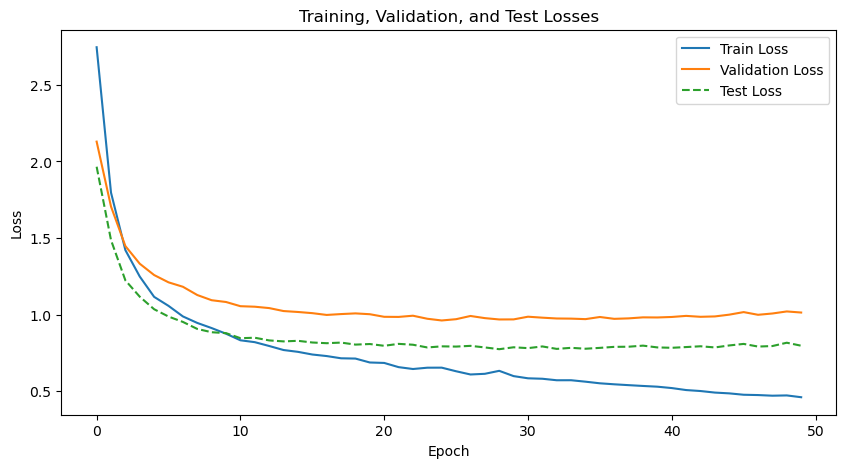

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(char2idx) + 1  # +1 for padding index 0
model = PropertyVAE(vocab_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 regularization

# Lists to store losses
train_losses = []
val_losses = []
test_losses = []

n_epochs = 50
best_val_loss = float('inf')
patience = 40
patience_counter = 0

for epoch in range(n_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for smiles, e_coh in train_loader:
        smiles, e_coh = smiles.to(device), e_coh.to(device)
        optimizer.zero_grad()
        recon_smiles, mean, logvar = model(smiles, e_coh)
        loss = vae_loss(recon_smiles, smiles, mean, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for smiles, e_coh in val_loader:
            smiles, e_coh = smiles.to(device), e_coh.to(device)
            recon_smiles, mean, logvar = model(smiles, e_coh)
            val_loss += vae_loss(recon_smiles, smiles, mean, logvar).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Test loss (per epoch)
    test_loss = 0.0
    with torch.no_grad():
        for smiles, e_coh in test_loader:
            smiles, e_coh = smiles.to(device), e_coh.to(device)
            recon_smiles, mean, logvar = model(smiles, e_coh)
            test_loss += vae_loss(recon_smiles, smiles, mean, logvar).item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Test Loss: {test_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Losses')
plt.legend()
plt.show()


In [12]:
# SMILES generation

model.eval()

generated_smiles = []
test_property_values = []

with torch.no_grad():
    for _, e_coh in test_loader:  # Only use E_coh, not SMILES
        e_coh = e_coh.to(device)
        batch_size = e_coh.size(0)
        
        # Sample latent vector from standard normal distribution
        latent_dim = model.decoder.init_h.weight.size(1) - 1  # Subtract 1 for property
        z = torch.randn(batch_size, latent_dim).to(device)
        
        # Generate SMILES for each property value in the batch
        recon_smiles_logits = model.decoder(z, e_coh, max_len, device, targets=None)
        
        # Convert logits to predicted token indices (greedily)
        pred_smiles = torch.argmax(recon_smiles_logits, dim=-1).cpu().numpy()
        
        # Convert token indices back to SMILES strings
        for i in range(batch_size):
            tokens = pred_smiles[i]
            tokens = tokens[tokens != 0]  # Remove padding (index 0)
            smiles_str = ''.join([idx2char[idx] for idx in tokens if idx in idx2char])
            generated_smiles.append(smiles_str)
            test_property_values.append(e_coh[i].item())

# Optionally, print or save the results
print("Generated SMILES and their E_coh values:")
for smiles, e_coh in zip(generated_smiles, test_property_values):
    print(f"{smiles}\t{e_coh:.4f}")

Generated SMILES and their E_coh values:
C=CC(=O)NC(C)CCCCCCCCCCCCCCCCCCCCC(=O)NC(=O)NC(C)C)c1ccccc1C(=O)NC(C)C)c1CCNC(=O)OC(C	0.3737
C=CC(=O)NCCCCCCCCCCCCCCCCCCCCCCCCCCC1=O)CCCCCCCCCCCCCCCC1=O)CCCCCCCCCCCCCCC1=O)CCCCCC	0.2261
C=C(C)C(=O)NC(C)CCCCCCCCCCCCCCCCC1C(=O)OCC(=O)OC(C)(C)C(=O)OC(C)(C)C)CC1C(=O)OC(=O)OC	0.5229
C(=O)NCCCCCCCCCCCC1CCOC(=O)C=C(C)C(=O)NC(C)CCCCC1CCOC(=O)C=C(C)C(=O)NC(C)CCCCC1CCOC(=	0.2955
C(=O)NCCCCCC1CCOC(=O)C=C(C)C(=O)OC(C)(C)C)C1CC(=O)OC(C)(C)C)C1CC(=O)OC(C)(C)C)C1CC(=O	0.5222
C(=O)NCCCCCC1CCOC(=O)C=CC(=O)NC(C)CC1CCOC1CCOCC1CCCCCCCCCCCCC1=O)CCCC1CCOCCCCCCCCCCCC	0.2734
C(=O)NC(C)C(=O)NC(C)C(=O)NC(C)C(=O)NC(C)C(=O)OC(C)(C)C)C(C)C(=O)OC(C)(C)C(=O)OC(C)(C)	0.4562
C(=O)NC(C)C(=O)NC(C)C(=O)NC(C)C(=O)NC(C)C(=O)NC(C)C(=O)NC(C)C(=O)NC(C)C(=O)NC(C)C(=O)	0.9870
C=CC(=O)NC(C)CCCCCCCC1CC(=O)OC(=O)C(C)C(C)C(=O)OC(C)(C)C(=O)OC(C)(C)C(=O)OC(C)(C)C(=O	0.3604
C(=O)NC(C)C(C)C(=O)NC(C)C(C)C(=O)NC(C)C(C)C(=O)NC(C)C(C)C(=O)NC(C)C(C)C(=O)NC(C)C(C)C	0.3285
C(C)C(=O)NCCCCCCCCCCCCCCCC1=O

In [13]:
from rdkit import Chem
from collections import Counter
from tqdm import tqdm  # For progress bar, install with: pip install tqdm

# 1. Validity: Check if each generated SMILES is chemically valid
valid_smiles = []
for smi in tqdm(generated_smiles, desc="Checking validity"):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_smiles.append(smi)
    except Exception as e:
        # Skip if parsing fails for any reason
        continue

validity_rate = len(valid_smiles) / len(generated_smiles) if generated_smiles else 0.0

# 2. Uniqueness: Fraction of unique valid SMILES
unique_valid_smiles = list(set(valid_smiles))
uniqueness_rate = len(unique_valid_smiles) / len(valid_smiles) if valid_smiles else 0.0

# 3. Novelty: Fraction of valid SMILES not present in the training set
# Get canonical SMILES from the training set
train_smiles_canon = set()
for smi, _ in tqdm(train_dataset, desc="Canonicalizing training SMILES"):
    try:
        # Get SMILES from tensor
        tokens = smi.cpu().numpy()
        tokens = tokens[tokens != 0]
        smi_str = ''.join([idx2char[idx] for idx in tokens if idx in idx2char])
        mol = Chem.MolFromSmiles(smi_str)
        if mol is not None:
            train_smiles_canon.add(Chem.MolToSmiles(mol))
    except Exception as e:
        # Skip if parsing fails for any reason
        continue

# Get canonical SMILES from the generated valid unique SMILES
novel_smiles = []
for smi in tqdm(unique_valid_smiles, desc="Checking novelty"):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            smi_canon = Chem.MolToSmiles(mol)
            if smi_canon not in train_smiles_canon:
                novel_smiles.append(smi_canon)
    except Exception as e:
        # Skip if parsing fails for any reason
        continue

novelty_rate = len(novel_smiles) / len(unique_valid_smiles) if unique_valid_smiles else 0.0

# Print metrics
print(f"Validity Rate: {validity_rate:.4f}")
print(f"Uniqueness Rate: {uniqueness_rate:.4f}")
print(f"Novelty Rate: {novelty_rate:.4f}")

Checking validity:   0%|                                                                                                                                                             | 0/41 [00:00<?, ?it/s][19:55:22] SMILES Parse Error: extra close parentheses while parsing: C=CC(=O)NC(C)CCCCCCCCCCCCCCCCCCCCC(=O)NC(=O)NC(C)C)c1ccccc1C(=O)NC(C)C)c1CCNC(=O)OC(C
[19:55:22] SMILES Parse Error: check for mistakes around position 51:
[19:55:22] CCCC(=O)NC(=O)NC(C)C)c1ccccc1C(=O)NC(C)C)
[19:55:22] ~~~~~~~~~~~~~~~~~~~~^
[19:55:22] SMILES Parse Error: Failed parsing SMILES 'C=CC(=O)NC(C)CCCCCCCCCCCCCCCCCCCCC(=O)NC(=O)NC(C)C)c1ccccc1C(=O)NC(C)C)c1CCNC(=O)OC(C' for input: 'C=CC(=O)NC(C)CCCCCCCCCCCCCCCCCCCCC(=O)NC(=O)NC(C)C)c1ccccc1C(=O)NC(C)C)c1CCNC(=O)OC(C'
[19:55:22] SMILES Parse Error: extra close parentheses while parsing: C=CC(=O)NCCCCCCCCCCCCCCCCCCCCCCCCCCC1=O)CCCCCCCCCCCCCCCC1=O)CCCCCCCCCCCCCCC1=O)CCCCCC
[19:55:22] SMILES Parse Error: check for mistakes around position 40:
[19:55:22] CCCCCCC

Validity Rate: 0.0976
Uniqueness Rate: 1.0000
Novelty Rate: 1.0000


At least for this code, there does not seem to be much improvement. However, with more data/training epochs/layers, the model is expected to improve in its predictions.